In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
nci = pd.read_csv("../raw/NCI60/IC50.csv")
nci.head()

,RELEASE_DATE,EXPID,PREFIX,NSC,CONCENTRATION_UNIT,LOG_HI_CONCENTRATION,PANEL_NUMBER,CELL_NUMBER,PANEL_NAME,CELL_NAME,PANEL_CODE,COUNT,AVERAGE,STDDEV
0,20210223,0001MD02,S,123127,M,-4.6021,1,21,Non-Small Cell Lung Cancer,NCI-H460,LNS,1,-8.1196,0.0
1,20210223,0001MD02,S,123127,M,-4.6021,10,14,Melanoma,M14,MEL,1,-6.7945,0.0
2,20210223,0001MD02,S,123127,M,-4.6021,12,16,CNS Cancer,SF-539,CNS,1,-6.6120,0.0
3,20210223,0001MD02,S,123127,M,-4.6021,4,10,Colon Cancer,COLO 205,COL,1,-6.3511,0.0
4,20210223,0001MD02,S,123127,M,-4.6021,4,9,Colon Cancer,SW-620,COL,1,-6.5272,0.0


In [3]:
nci_gdsc_codes = pd.read_csv("../processed/nci_codes.csv")
# note: CELL_NAME and cell_line mean the same thing
nci_gdsc_codes = nci_gdsc_codes.rename(columns={"nci": "CELL_NAME", "gdsc":"gdsc_name"})
nci_gdsc_codes.head()

,CELL_NAME,gdsc_name
0,MCF7,MCF7
1,MDA-MB-231/ATCC,MDA-MB-231
2,HS 578T,Hs-578-T
3,BT-549,BT-549
4,T-47D,T47D


In [4]:
nci_prep = nci.loc[nci["CONCENTRATION_UNIT"] == 'M'].copy()
nci_prep = pd.merge(nci_prep, nci_gdsc_codes, on='CELL_NAME', how='left')
nci_prep = nci_prep.dropna(subset=["gdsc_name"])
nci_prep['AVERAGE'] = nci_prep.loc[:, 'AVERAGE'].apply(lambda x : -x - 6)
nci_prep['AVERAGE'] = nci_prep.loc[:, 'AVERAGE'].clip(lower=-4, upper=4)
nci_prep.head()

,RELEASE_DATE,EXPID,PREFIX,NSC,CONCENTRATION_UNIT,LOG_HI_CONCENTRATION,PANEL_NUMBER,CELL_NUMBER,PANEL_NAME,CELL_NAME,PANEL_CODE,COUNT,AVERAGE,STDDEV,gdsc_name
0,20210223,0001MD02,S,123127,M,-4.6021,1,21,Non-Small Cell Lung Cancer,NCI-H460,LNS,1,2.1196,0.0,NCI-H460
1,20210223,0001MD02,S,123127,M,-4.6021,10,14,Melanoma,M14,MEL,1,0.7945,0.0,M14
2,20210223,0001MD02,S,123127,M,-4.6021,12,16,CNS Cancer,SF-539,CNS,1,0.6120,0.0,SF539
3,20210223,0001MD02,S,123127,M,-4.6021,4,10,Colon Cancer,COLO 205,COL,1,0.3511,0.0,COLO-205
4,20210223,0001MD02,S,123127,M,-4.6021,4,9,Colon Cancer,SW-620,COL,1,0.5272,0.0,SW620


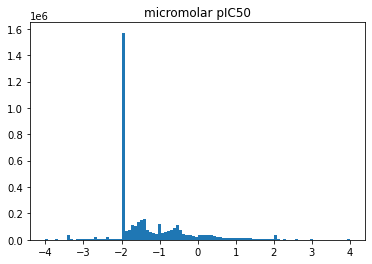

In [5]:
plt.hist(nci_prep['AVERAGE'], bins=100)
plt.title("micromolar pIC50")
plt.show()

In [6]:
nsc_smiles = pd.read_csv("../processed/nsc_smiles.csv")
nsc_smiles.head()

,NSC,SMILES
0,1,CC1=CC(=O)C=CC1=O
1,2,S(Sc1nc2ccccc2s1)c3nc4ccccc4s3
2,3,Oc1c(Cl)cc(cc1[N+](=O)[O-])[N+](=O)[O-]
3,4,Nc1ncc(s1)[N+](=O)[O-]
4,5,Nc1ccc2C(=O)c3ccccc3C(=O)c2c1


In [7]:
nci_prep_smiles = pd.merge(nci_prep, nsc_smiles, on="NSC", how="left")
nci_prep_smiles.rename(columns={
    "AVERAGE": "pIC50",
    "SMILES":"smiles",
    "PANEL_CODE": "panel",
    "gdsc_name": "cell_line"
}, inplace=True)
nci_prep_smiles = nci_prep_smiles[pd.notna(nci_prep_smiles["smiles"])]
nci_final = nci_prep_smiles[["cell_line", "panel", "smiles", "pIC50"]]
nci_final.head()

,cell_line,panel,smiles,pIC50
0,NCI-H460,LNS,COc1cccc2C(=O)c3c(O)c4C[C@](O)(C[C@H](OC5CC(N)...,2.1196
1,M14,MEL,COc1cccc2C(=O)c3c(O)c4C[C@](O)(C[C@H](OC5CC(N)...,0.7945
2,SF539,CNS,COc1cccc2C(=O)c3c(O)c4C[C@](O)(C[C@H](OC5CC(N)...,0.6120
3,COLO-205,COL,COc1cccc2C(=O)c3c(O)c4C[C@](O)(C[C@H](OC5CC(N)...,0.3511
4,SW620,COL,COc1cccc2C(=O)c3c(O)c4C[C@](O)(C[C@H](OC5CC(N)...,0.5272


In [8]:
len(nci_final)

4092794

In [9]:
nci_final.to_csv("../processed/nci_cdr_preprocess.csv", index=False)